# LIMEを用いたMNIST画像分類

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, initializers
from tensorflow.keras.datasets import mnist

np.random.seed(1)
tf.random.set_seed(1)

print("tensorflow version : " + tf.__version__)

tensorflow version : 2.6.0


# データセットの取得

In [2]:
from skimage.color import gray2rgb

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_val = x_train[:5000]
x_train = x_train[5000:15000]
y_val = y_train[:5000]
y_train = y_train[5000:15000]

x_test = x_test[:5000]
y_test = y_test[:5000]

#LIMEは3次元の画像に対応しているため変換する
x_train = gray2rgb(x_train) 
x_val = gray2rgb(x_val)
x_test = gray2rgb(x_test)

x_train = x_train.reshape((-1, 28, 28, 3))
x_train = x_train.astype('float64') / 255

x_val = x_val.reshape((-1, 28, 28, 3))
x_val = x_val.astype('float64') / 255

x_test = x_test.reshape((-1, 28, 28, 3))
x_test = x_test.astype('float64') / 255

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print('x_val.shape: ', x_val.shape)
print('y_val.shape: ', y_val.shape)
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

x_train.shape:  (10000, 28, 28, 3)
y_train.shape:  (10000, 10)
x_val.shape:  (5000, 28, 28, 3)
y_val.shape:  (5000, 10)
x_test.shape:  (5000, 28, 28, 3)
y_test.shape:  (5000, 10)


# モデルの作成

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(10, activation='softmax', name='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2704)              0         
_________________________________________________________________
softmax (Dense)              (None, 10)                27050     
Total params: 27,498
Trainable params: 27,498
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
79/79 [==============================] - 6s 63ms/step - loss: 0.8702 - accuracy: 0.7721 - val_loss: 0.3184 - val_accuracy: 0.9146
Epoch 2/5
79/79 [==============================] - 4s 55ms/step - loss: 0.2907 - accuracy: 0.9160 - val_loss: 0.2413 - val_accuracy: 0.9326
Epoch 3/5
79/79 [==============================] - 4s 56ms/step - loss: 0.2118 - accuracy: 0.9412 - val_loss: 0.1871 - val_accuracy: 0.9468
Epoch 4/5
79/79 [==============================] - 4s 56ms/step - loss: 0.1617 - accuracy: 0.9537 - val_loss: 0.1711 - val_accuracy: 0.9524
Epoch 5/5
79/79 [==============================] - 4s 56ms/step - loss: 0.1303 - accuracy: 0.9634 - val_loss: 0.1487 - val_accuracy: 0.9572


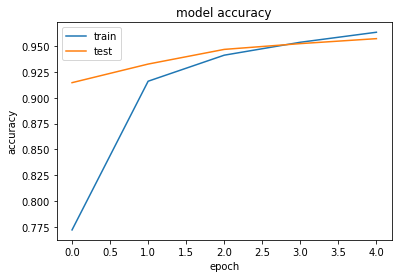

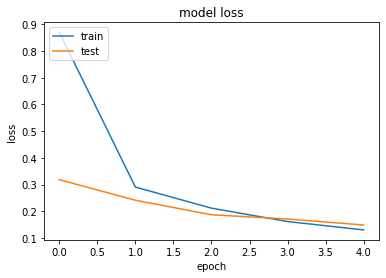

In [4]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

training = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    batch_size=128, epochs=5)

#正答率
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# LIMEによるモデルの可視化

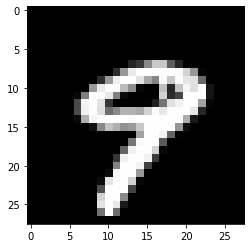

In [5]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import random

image_index = 9
plt.imshow(x_test[image_index])

## モデルの推定結果の表示

In [6]:
df = pd.DataFrame(model.predict(x_test[image_index].reshape((1,28,28,3))), index=['pred_result'])
df = df.transpose()
df = df.sort_values('pred_result', ascending=False)
df

,pred_result
9,9.816633e-01
7,1.524893e-02
8,2.328046e-03
4,5.226585e-04
3,1.251621e-04
5,5.881193e-05
0,2.628334e-05
2,2.617627e-05
6,5.749394e-07
1,2.441434e-08


In [7]:
explainer = lime_image.LimeImageExplainer(random_state=42)
exp = explainer.explain_instance(
         x_test[image_index], 
         model.predict
)

print('LIME predict result : ', exp.top_labels)

  0%|          | 0/1000 [00:00<?, ?it/s]

LIME predict result :  [9, 7, 8, 4, 3]


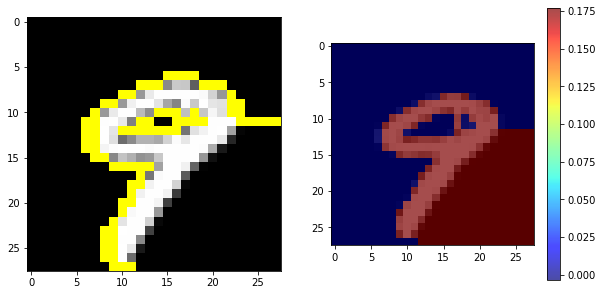

In [8]:
pred_result = df.index[0] #最も高い推定結果について可視化する

fig = plt.figure(figsize=[10,5])

image, mask = exp.get_image_and_mask(
         pred_result,
         positive_only=True, 
         hide_rest=False)

fig.add_subplot(1, 2, 1)
plt.imshow(mark_boundaries(image, mask))


dict_heatmap = dict(exp.local_exp[pred_result])
heatmap = np.vectorize(dict_heatmap.get)(exp.segments)

fig.add_subplot(1, 2, 2)
plt.imshow(x_test[image_index])
plt.imshow(heatmap, alpha=0.7, cmap='jet')
plt.colorbar()

# segmentation algorithmの設定

画像の一部をセグメントとして分割し、セグメント単位で値を変更することによってモデルの内容を分析する

セグメントへの分割方法にもいくつか存在し、使用する手法によって分割方法が異なる

もちろん分割方法によってLIMEの結果にも影響を及ぼす

c:\users\naolu\documents\github\xai_samples\.venv\lib\site-packages\lime\wrappers\scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


Text(0.5, 1.0, 'felzenszwalb')

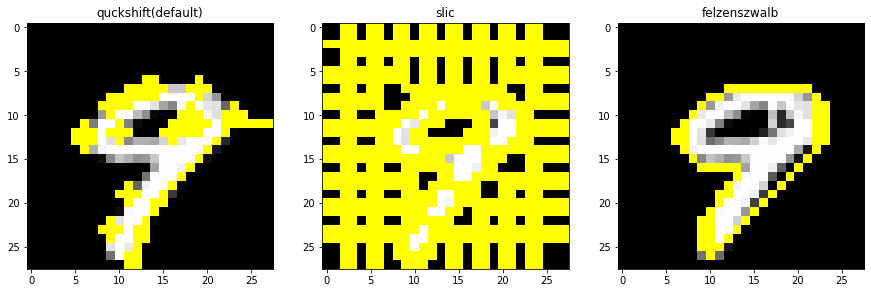

In [9]:
from lime.wrappers.scikit_image import SegmentationAlgorithm

fig = plt.figure(figsize=[15,5])

# quick shift segmentation algorithm
quick_shift_seg_fn = SegmentationAlgorithm(
    'quickshift',
    kernel_size=4,
    max_dist=200,
    radio=0.2,
    random_seed=42
)
quick_shift_seg = quick_shift_seg_fn(x_test[image_index])

fig.add_subplot(1, 3, 1)
plt.imshow(mark_boundaries(np.array(x_test[image_index]), quick_shift_seg))
plt.title('quckshift(default)')

# slic segmenatation algorithm
slic_seg_fn = SegmentationAlgorithm(
    'slic',
)

slic_seg = slic_seg_fn(x_test[image_index])
fig.add_subplot(1, 3, 2)
plt.imshow(mark_boundaries(np.array(x_test[image_index]), slic_seg))
plt.title('slic')

#felzenzwalb segmentation algorithm
felzenzwalb_seg_fn = SegmentationAlgorithm(
    'felzenszwalb',
)

felzenzwalb_seg = felzenzwalb_seg_fn(x_test[image_index])
fig.add_subplot(1, 3, 3)
plt.imshow(mark_boundaries(np.array(x_test[image_index]), felzenzwalb_seg))
plt.title('felzenszwalb')

# segment algorithmによる結果差分の確認
LIMEの分類結果の上位5つの分類について、セグメント分割ごとに可視化した

それぞれの図においてヒートマップの値が高い部分が分類において特徴的な部分になっている


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\naolu\documents\github\xai_samples\.venv\lib\site-packages\lime\wrappers\scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

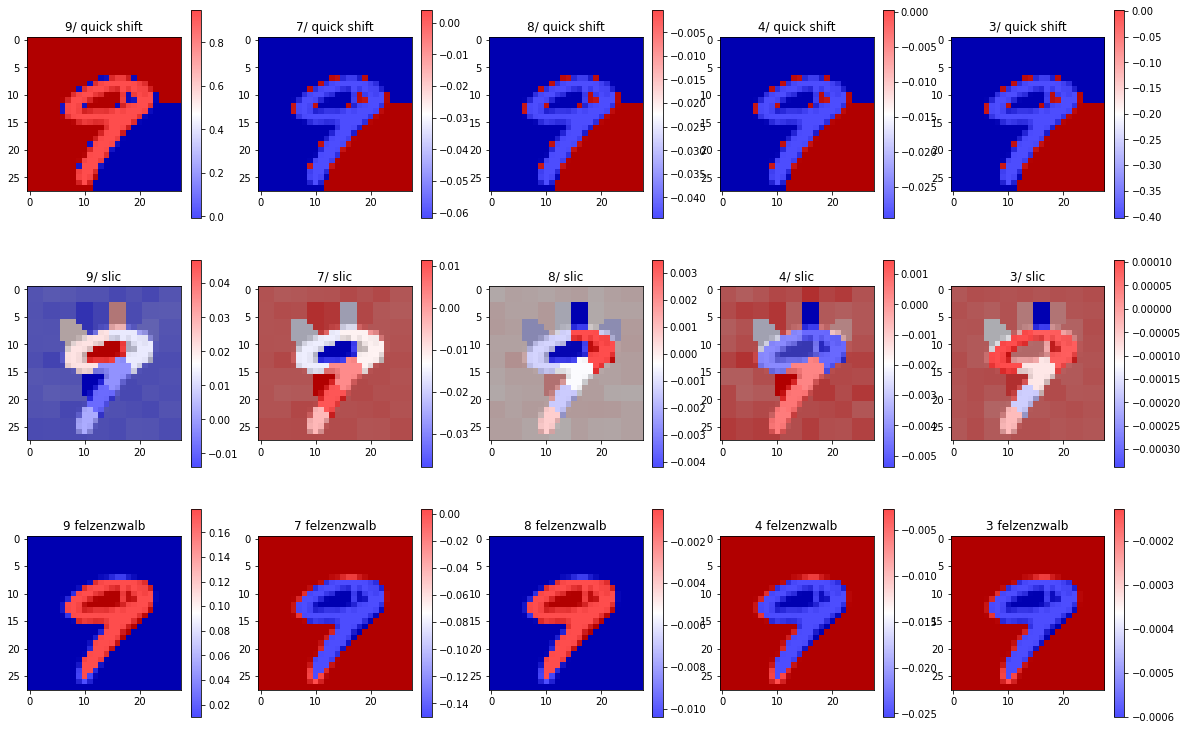

In [10]:
def select_seg(i):
    if i % 3 == 0:
        seg = quick_shift_seg_fn
    elif i % 3 == 1:
        seg = slic_seg_fn
    else:
        seg = felzenzwalb_seg_fn
    return seg


fig = plt.figure(figsize=[20,13])

for i in range(3):
    exp = explainer.explain_instance(
         x_test[image_index], 
         model.predict,
         segmentation_fn=select_seg(i)
    )
    
    for j in range(5):
        pred_result = df.index[j]

        dict_heatmap = dict(exp.local_exp[pred_result])
        heatmap = np.vectorize(dict_heatmap.get)(exp.segments)

        fig.add_subplot(3, 5, i*5+j+1)
        plt.imshow(x_test[image_index])
        plt.imshow(heatmap, alpha=0.7, cmap='bwr')
        plt.colorbar()
        if i % 3 == 0:
            plt.title(str(pred_result) + '/ quick shift')
        elif i % 3 == 1:
            plt.title(str(pred_result) + '/ slic')
        else:
            plt.title(str(pred_result) + ' felzenzwalb')